# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></div><div class="lev1 toc-item"><a href="#Build-Model" data-toc-modified-id="Build-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Build Model</a></div><div class="lev2 toc-item"><a href="#Set-Hyperparameters" data-toc-modified-id="Set-Hyperparameters-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Set Hyperparameters</a></div><div class="lev2 toc-item"><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Import Libraries</a></div><div class="lev2 toc-item"><a href="#Build-Graph" data-toc-modified-id="Build-Graph-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Build Graph</a></div><div class="lev1 toc-item"><a href="#Train" data-toc-modified-id="Train-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train</a></div>

# Load Data

In [1]:
import h5py
import pickle

In [2]:
with h5py.File('/Users/lizhn7/Downloads/EXPERIMENT/COPA/LM/data/x.h5', 'r') as fh:
    x = fh['x'][:]

with h5py.File('/Users/lizhn7/Downloads/EXPERIMENT/COPA/LM/data/y.h5', 'r') as fh:
    y = fh['y'][:]

with h5py.File('/Users/lizhn7/Downloads/EXPERIMENT/COPA/LM/data/embedding.h5', 'r') as fh:
    embedding = fh['embedding'][:]
    
with open('/Users/lizhn7/Downloads/EXPERIMENT/COPA/LM/data/index.pkl', 'rb') as fp:
    word2index, index2word, glove_index2index = pickle.load(fp)

# Build Model

## Set Hyperparameters

In [38]:
NUM_GRAMS = 25
NUM_UNK_WORDS = 5
VOCAB_SIZE = 20000
EMBEDDING_DIM = 200
BATCH_SIZE = 1024
NUM_EPOCHS = 2
RNN_SIZE = 1024

## Import Libraries

In [3]:
from keras.layers import Input, Embedding, LSTM, Dense, Dropout
from keras.models import Model
import keras.backend as K
from keras.callbacks import*
import numpy as np
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


## Build Graph

In [33]:
K.clear_session()
# Encoder
inputs = Input(shape=(None,), name='EN_INPUT', dtype='int64')
emb_seq = Embedding(VOCAB_SIZE, 
                    EMBEDDING_DIM, 
                    weights=[embedding], 
                    mask_zero=True, 
                    trainable=False, 
                    name='EN_EMBEDDING')(inputs)
lstm = LSTM(RNN_SIZE, return_sequences=False, implementation=0, name='EN_LSTM')(emb_seq)
encoder = Model(inputs=inputs, outputs=lstm)

# Language Model
input_grams = Input(shape=(NUM_GRAMS,), name='LM_INPUT', dtype='int64')
encoded_grams = encoder(input_grams)
outputs = Dense(VOCAB_SIZE, activation='softmax', name='LM_OUTPUT')(encoded_grams)
lm = Model(inputs=input_grams, outputs=outputs)
lm.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EN_INPUT (InputLayer)        (None, None)              0         
_________________________________________________________________
EN_EMBEDDING (Embedding)     (None, None, 200)         4000000   
_________________________________________________________________
EN_LSTM (LSTM)               (None, 1024)              5017600   
Total params: 9,017,600
Trainable params: 5,017,600
Non-trainable params: 4,000,000
_________________________________________________________________


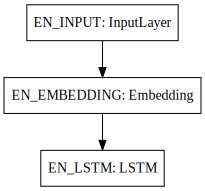

In [20]:
encoder.summary()
SVG(model_to_dot(encoder).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LM_INPUT (InputLayer)        (None, 25)                0         
_________________________________________________________________
model_1 (Model)              (None, 1024)              9017600   
_________________________________________________________________
LM_OUTPUT (Dense)            (None, 20000)             20500000  
Total params: 29,517,600
Trainable params: 25,517,600
Non-trainable params: 4,000,000
_________________________________________________________________


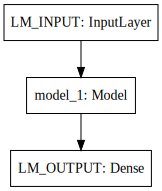

In [21]:
lm.summary()
SVG(model_to_dot(lm).create(prog='dot', format='svg'))

# Train

In [47]:
filepath = '/Users/lizhn7/Downloads/EXPERIMENT/COPA/LM/cp_logs/weights.{epoch:03d}-{loss:.6f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [49]:
def data_generator(data, label, batch_size): 
    """
    Yield batches 
    """
    index = np.arange(len(data))
    np.random.shuffle(index)    
    batches = [index[range(batch_size*i, min(len(data), batch_size*(i+1)))] for i in range(len(data)//batch_size)]
    while True:
        for i in batches:
            x = data[i]
            y = label[i]
            yield (x, y)

In [54]:
gen_train = data_generator(x[:2048], y[:2048], BATCH_SIZE)

In [57]:
history = lm.fit_generator(gen_train,
                           steps_per_epoch=3,
                           epochs=NUM_EPOCHS,
                           callbacks=callbacks_list)

Epoch 1/2
3/3 [==============================] - 91s - loss: 5.6102     
Epoch 2/2
3/3 [==============================] - 97s - loss: 5.5730     
